# Catboost

✅간략한 설명
* Boosting 기반의 모델
* GBM은 치명적인 문제로 과적합 문제가 존재하는데, Catboost는 과적합 문제를 해결함과 동시에 기존 GBM 계열 알고리즘인 Xgboost, LightGBM 알고리즘보다 학습속도를 개선하는 장점을 갖음 
* 또한 XGBoost, LightGBM이 Hyperparameter에 민감한 문제를 해결하는 것에 초점을 맞춘 모델임 
* 대부분이 범주형변수로 이루어진 데이터셋에서 예측 성능이 우수한 것으로 알려져 있음
* 범주형 변수를 One-hot enoding, Label encoding 등 encoding 작업을 하지 않고도 그대로 모델의 input으로 사용할 수 있다는 장점이 있음 

![](img/2022-12-01-16-36-01.png)

✅사용할 데이터 설명
* 문제 : 신용카드 사용자의 연쳬를 예측함
* train : 신용카드 사용자들의 개인 신상정보 (credit 열 포함)
* test : 신용카드 사용자들의 개인 신상정보 (credit 열 미포함)

## 라이브러리 불러오기

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool



## 데이터 불러오기

In [16]:
path = 'C:/Users/JiwonMoon/Desktop/Data/open/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

## 데이터 전처리

### 1. 결측치 처리

In [17]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [20]:
train.fillna('NaN',inplace=True)
test.fillna('NaN', inplace=True)

### 2. 이상치 처리

In [21]:
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

## Feature Engineering

### 1. 의미없는 변수 제거

In [22]:
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

### 2. Days_Employed가 양수인 데이터는 무직자로 판단, 0처리

In [23]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

### 3. Days_birth, begin_month, days_employed 음수-> 양수 변환

In [24]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

### 4. 파생변수 

In [25]:
for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)

     #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

     #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    
    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']

    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)




In [27]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean,ID
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,...,0.0,38,7.0,1.0,12,0.0,0.0,10.882416,101250.0,0_202500.0_13899_4709_0_0_0_2.0_F_N_N_Commerci...
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,...,1.0,31,7.0,1.0,4,3.0,0.0,19.156347,82500.0,1_247500.0_11380_1540_0_0_1_3.0_F_N_Y_Commerci...
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,...,1.0,52,0.0,2.0,12,3.0,1.0,19.131840,225000.0,0_450000.0_19087_4434_0_1_0_2.0_M_Y_Y_Working_...
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,...,0.0,41,10.0,3.0,5,9.0,2.0,11.786962,101250.0,0_202500.0_15088_2092_0_1_0_2.0_F_N_Y_Commerci...
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,...,3.0,41,9.0,0.0,5,10.0,0.0,9.187959,78750.0,0_157500.0_15037_2105_0_0_0_2.0_F_Y_Y_State se...


### 5. 파생변수와 다중공선성을 보이는 칼럼 삭제

In [28]:
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED',]
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

## Scaling, Encoding

### 1. Numeric Category 컬럼 분류

In [29]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  18
Number of Categorical features:  9


In [30]:
numerical_feats

['income_total',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 'before_EMPLOYED',
 'income_total_befofeEMP_ratio',
 'before_EMPLOYED_m',
 'before_EMPLOYED_w',
 'Age',
 'DAYS_BIRTH_m',
 'DAYS_BIRTH_w',
 'EMPLOYED',
 'DAYS_EMPLOYED_m',
 'DAYS_EMPLOYED_w',
 'ability',
 'income_mean']

In [31]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'ID']

### 2.Log Scale

In [32]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

### 3. OrdinalEncoder
* Categorial feature에 대한 순서형 코딩이라고 하며, 각 범주들을 특성으로 변경하지 않고, 그 안에서 1,2,3등의 숫자로 변경하는 방법. 
* 범주가 너무 많아 one hot encoding을 하기 애매한 상황에서 이용하기 좋은 인코딩 방법. 
* 트리 모델은 중요한 feature가 상위 노드를 점하여 분할을 하게 되는데, one hot encoding을 한 feature는 뽑히기에 불리한 상태가 되므로 대안으로 사용함 
* 카테고리 변수는 ordinal_encoder 변환
* ID는 변환 후 정수 처리

In [33]:
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

### 4. 클러스터링 구성 
타겟을 결정짓는 뚜렷한 특징을 갖는 feature를 찾지 못해 clustering 시도

In [34]:
kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

In [35]:
train['cluster']

0        35
1         7
2        18
3        35
4         7
         ..
26446    31
26447    10
26448    32
26449    13
26450    23
Name: cluster, Length: 26451, dtype: int32

### 4. StandardScale
이미 로그변환을 진행한 income_total을 제외한 나머지 numeric 컬럼 정규화

In [37]:
numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])


## Modeling- catboost

fold수를 15로 설정

In [38]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [46]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds = []

for train_idx,valid_idx in skfold.split(X,y):
    folds.append((train_idx,valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))

cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')



----------------- Fold 0 -----------------

Learning rate set to 0.115127
0:	learn: 1.0346960	test: 1.0333820	best: 1.0333820 (0)	total: 156ms	remaining: 2m 35s
100:	learn: 0.7044704	test: 0.6427096	best: 0.6427096 (100)	total: 3.32s	remaining: 29.6s
200:	learn: 0.6843687	test: 0.6403953	best: 0.6402982 (176)	total: 6.43s	remaining: 25.6s
300:	learn: 0.6680286	test: 0.6392776	best: 0.6392019 (296)	total: 9.46s	remaining: 22s
400:	learn: 0.6515064	test: 0.6392338	best: 0.6388684 (397)	total: 12.5s	remaining: 18.7s
500:	learn: 0.6338447	test: 0.6414953	best: 0.6386980 (412)	total: 15.5s	remaining: 15.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6386980408
bestIteration = 412

Shrink model to first 413 iterations.
CV Log Loss Score: 0.638698

----------------- Fold 1 -----------------

Learning rate set to 0.115127
0:	learn: 1.0346110	test: 1.0339653	best: 1.0339653 (0)	total: 10.4ms	remaining: 10.4s
100:	learn: 0.7034876	test: 0.6759823	best: 0.6757272 (93)	to

## Feature Importance

In [47]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

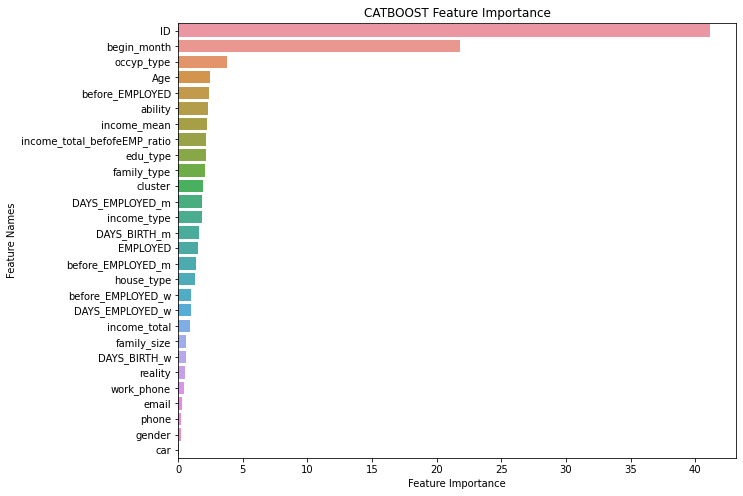

In [48]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

### Reference
https://dacon.io/competitions/official/235713/codeshare/2768?page=1&dtype=recent